In [1]:
#  !git clone https://github.com/sid-shnkar/Social-Media-Toxic-Comments-Classification.git

Cloning into 'Social-Media-Toxic-Comments-Classification'...
Updating files: 100% (6/6)
Updating files: 100% (6/6), done.


In [54]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, hamming_loss, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import pandas as pd
import numpy as np
import re
import string
import warnings
import joblib
import os
import pandas as pd
import importlib
import sys
sys.path.append(os.path.abspath("../"))  # Add directory
import eval_metrics  # Import module
import balance_df
# Reload if modified
importlib.reload(eval_metrics)
from eval_metrics import evaluate_model, custom_threshold_condition
from balance_df import balance_dataset

In [2]:
svm_classifier = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
                    intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                    multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
                    verbose=0)

lr_classifier = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                     intercept_scaling=1, max_iter=100, multi_class='auto',
                                     n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
                                     tol=0.0001, verbose=0, warm_start=False)
xgb_classifier=xgb.XGBClassifier()

In [4]:
%cd Ensemble

/home/mb05005/mudit/Threat/Ensemble


In [5]:
# Load the saved ensemble model
ensemble_clf = joblib.load('./LinearSVC_git/ensemble.pkl')

In [11]:
def tokenize_text(text):
    text=text.lower()
    regular_expr=re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    without_punctuation=regular_expr.sub(" ",text)
    
    tokenize_words=without_punctuation.split(' ')
    tokenize_words=[word.encode('ascii','ignore').decode('ascii') for word in tokenize_words]
    
    lemmatizer=WordNetLemmatizer()
    tokenize_words=[lemmatizer.lemmatize(word) for word in tokenize_words]
    
    tokenize_words=[word for word in tokenize_words if len(word) > 2]
    
    return tokenize_words

In [13]:
# Load the saved TF-IDF vectorizer
tfidf_vector = joblib.load('./LinearSVC_git/tfidf_vectorizer.pkl')

In [15]:
print(len(tfidf_vector.vocabulary_))  # If this returns a number > 0, it's fitted

19119


In [17]:
def preprocess_and_transform(pd_dataframe, vectorizer_path='/home/mb05005/mudit/Threat/Ensemble/LinearSVC_git/tfidf_vectorizer.pkl'):
    """
    Preprocess and transform text data using a pre-trained TfidfVectorizer.

    Parameters:
        dataset_path (str): Path to the dataset CSV file containing the text data.
        vectorizer_path (str): Path to the saved TfidfVectorizer file.

    Returns:
        X_new (sparse matrix): Transformed text data as a TF-IDF feature matrix.
        new_dataset (DataFrame): Original dataset for further reference.
    """
    
    # Extract the text column
    new_text = pd_dataframe['comment_text']  # Ensure this column matches your dataset
    
    
    # Transform the new text data using the vectorizer
    X_new = tfidf_vector.transform(new_text)
    
    return X_new

# Predict labels for the new dataset
def predictions(model, X_new):
    predictions = model.predict(X_new)
    predict_df = pd.DataFrame(predictions,columns=['Prediction label'])
    return predict_df

### Dataset 1: Toxic Comment Classification

In [24]:
toxiccomment = pd.read_csv('..//Datasets/toxiccomment/toxiccomment.csv')
toxiccomment.head()

,id,comment_text,true_label
0,55858b89f99e9bda,Hope he dies \n\nNow this Atheist filth's wife...,1
1,425a1dbdf740e9b8,"2006 (UTC)\n\n Removed Merge 17:15, 5 April",0
2,20c81b99f7adf557,John discuss it here \n\nSeems you don't like ...,0
3,af0dce6ce84974ec,"""\nTo answer your question, no. There is no si...",0
4,a069e6d6d1a2348d,"""\n But Arpad can cite any webpage he finds, o...",0


In [28]:

# Transform the new text data using the vectorizer
X_new = tfidf_vector.transform(toxiccomment['comment_text'])

In [30]:
# Predict labels for the new dataset
predictions = ensemble_clf.predict(X_new)
predict_df = pd.DataFrame(predictions,columns=['pred_label'])
predict_df.head()

,pred_label
0,0
1,0
2,0
3,0
4,0


In [32]:
predict_df['pred_label'].value_counts()

pred_label
0    1319
1      59
Name: count, dtype: int64

In [34]:
toxiccomment['pred_label'] = predict_df['pred_label'].tolist()
toxiccomment.head()

,id,comment_text,true_label,pred_label
0,55858b89f99e9bda,Hope he dies \n\nNow this Atheist filth's wife...,1,0
1,425a1dbdf740e9b8,"2006 (UTC)\n\n Removed Merge 17:15, 5 April",0,0
2,20c81b99f7adf557,John discuss it here \n\nSeems you don't like ...,0,0
3,af0dce6ce84974ec,"""\nTo answer your question, no. There is no si...",0,0
4,a069e6d6d1a2348d,"""\n But Arpad can cite any webpage he finds, o...",0,0


In [36]:
toxiccomment.to_csv('ensemble_toxiccomment.csv',index=False)

In [38]:
from sklearn.metrics import f1_score, recall_score, hamming_loss

# Assuming 'new_labels' contains the true labels for the 'threat' column
new_labels = toxiccomment['true_label']  # Replace with the actual column name for true labels
predicted_labels = predict_df['pred_label']  # Replace with the actual column name for predictions

# Calculate Accuracy, F1-Score and Recall for 'threat'
f1 = f1_score(new_labels, predicted_labels, average="weighted")
recall = recall_score(new_labels, predicted_labels, average="weighted")
acc = accuracy_score(new_labels, predicted_labels)
# Calculate Hamming Loss for 'threat'
hamming_loss_score = hamming_loss(new_labels, predicted_labels)

# Print Results
print("Accuracy: ",acc)
print("F1-Score (threat):", f1)
print("Recall (threat):", recall)
print("Hamming Loss (threat):", hamming_loss_score)


Accuracy:  0.5399129172714079
F1-Score (threat): 0.41833468265973534
Recall (threat): 0.5399129172714079
Hamming Loss (threat): 0.46008708272859217


### Dataset 2: Jigsaw Unintended Bias

In [40]:
jigsaw = pd.read_csv("..//Datasets/jigsaw/jigsaw.csv")
jigsaw.head()

,id,comment_text,toxicity,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,Threat_Jigsaw,toxicity_annotator_count,true_label
0,304799,Is your concern satisfied by the fact that the...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,4,0
1,5293619,Comey's firing is a separate issue from the ma...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,4,0
2,5009206,klastri> besides the legal points. She shoul...,0.500000,0.1,0.000000,0.0,0.000000,0.100000,0.500000,10,1
3,6122758,Trump has been the only one to threaten to wip...,0.536232,0.0,0.086957,0.0,0.057971,0.536232,0.043478,69,0
4,6018742,"Just listen to yourself.\n""the swamp"" (twice!)...",0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,4,0


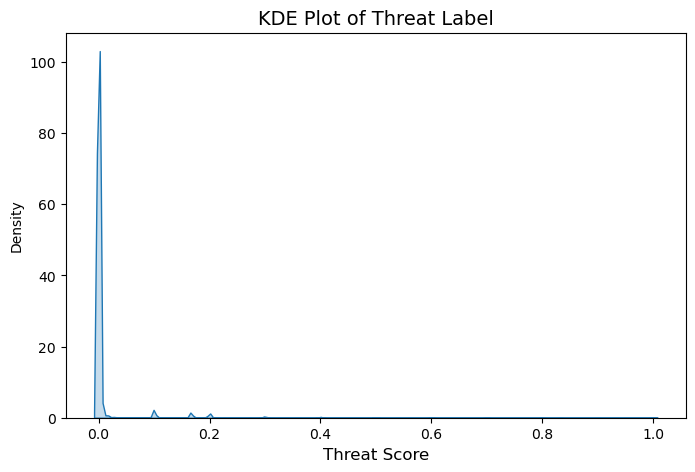

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot the distribution for the 'threat' label
plt.figure(figsize=(8, 5))
sns.kdeplot(jigsaw['threat'], fill=True)
plt.title('KDE Plot of Threat Label', fontsize=14)
plt.xlabel('Threat Score', fontsize=12)
plt.show()

In [42]:
X_new = tfidf_vector.transform(jigsaw['comment_text'])

In [44]:
predictions = ensemble_clf.predict(X_new)
jigsaw['pred_label'] = predictions

In [50]:
evaluate_model(jigsaw['true_label'],jigsaw['pred_label'])

Evaluation Metrics for Threat:
  Accuracy: 0.6032
  F1-Score: 0.4573
  Recall: 0.6032
  Hamming Loss: 0.3968


{'Accuracy': 0.6032128514056225,
 'F1-Score': 0.4572799345876053,
 'Recall': 0.6032128514056225,
 'Hamming Loss': 0.3967871485943775}


📊 Classification Report:
              precision    recall  f1-score   support

  Non-Threat       0.60      1.00      0.75       747
      Threat       1.00      0.01      0.02       498

    accuracy                           0.60      1245
   macro avg       0.80      0.50      0.38      1245
weighted avg       0.76      0.60      0.46      1245


✅ Accuracy: 0.6032
✅ Precision: 1.0000
✅ Recall: 0.0080
✅ F1 Score: 0.0159


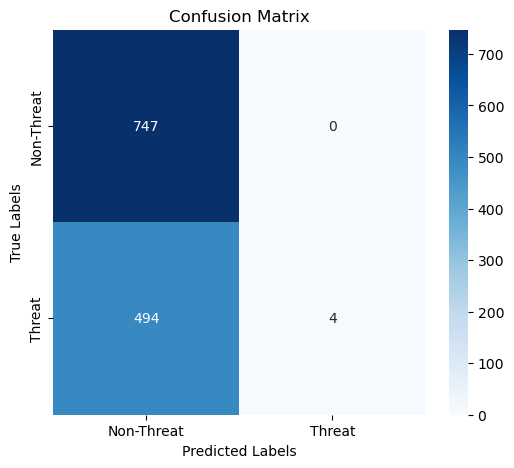

In [56]:
evaluate_model(y_true=jigsaw['true_label'], y_pred=jigsaw['pred_label'], class_labels=["Not Threat", "Threat"])

### Dataset 3: Combined Pronaity Toxicity

In [64]:
combined = pd.read_csv("..//Datasets/Combined_toxicity_profanity/combined_en.csv")
combined.head()

,text,labels,encoded_labels,true_label
0,Agree. The number of morons that shoot animal...,['toxic' 'threat' 'insult'],"[1, 0, 1, 0, 1, 0, 0, 0, 0]",1
1,"""As long as we get to shoot them at some point...",['toxic' 'threat'],"[1, 0, 0, 0, 1, 0, 0, 0, 0]",1
2,mad know take never felt angry mad never get g...,['selfharm'],"[0, 0, 0, 0, 0, 0, 0, 1, 0]",0
3,The RINOS in charge of the Congress would neve...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0
4,Which of Trump's appointments do you believe w...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0


In [66]:
X_new = tfidf_vector.transform(combined['text'])
predictions = ensemble_clf.predict(X_new)
jigsaw['pred_label'] = predictions

In [68]:
def transform_and_predict(text,vectorizer=tfidf_vector,model=ensemble_clf):
    X_new = vectorizer.transform(text)
    predictions = model.predict(X_new)
    return predictions

In [70]:
combined['pred_label']=transform_and_predict(combined['text'])

In [72]:
combined.head()

,text,labels,encoded_labels,true_label,pred_label
0,Agree. The number of morons that shoot animal...,['toxic' 'threat' 'insult'],"[1, 0, 1, 0, 1, 0, 0, 0, 0]",1,0
1,"""As long as we get to shoot them at some point...",['toxic' 'threat'],"[1, 0, 0, 0, 1, 0, 0, 0, 0]",1,0
2,mad know take never felt angry mad never get g...,['selfharm'],"[0, 0, 0, 0, 0, 0, 0, 1, 0]",0,0
3,The RINOS in charge of the Congress would neve...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0,0
4,Which of Trump's appointments do you believe w...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0,0



📊 Classification Report:
              precision    recall  f1-score   support

  Non-Threat       0.60      1.00      0.75       516
      Threat       1.00      0.01      0.03       344

    accuracy                           0.61       860
   macro avg       0.80      0.51      0.39       860
weighted avg       0.76      0.61      0.46       860


✅ Accuracy: 0.6058
✅ Precision: 1.0000
✅ Recall: 0.0145
✅ F1 Score: 0.0287


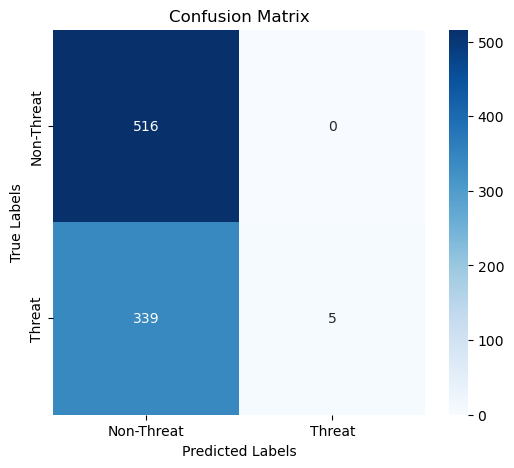

In [74]:
evaluate_model(y_true=combined['true_label'],y_pred=combined['pred_label'],class_labels=['Not Threat','Threat'])

### Suspicious Tweets

In [81]:
sus = pd.read_csv('..//Datasets/kaggle_suspicious/suspicious_tweets.csv')
sus.head()

,message,label
0,@MsLynnGallo Never mind - You missed the joke ...,0
1,turns out there had been #earthquake warnings ...,1
2,@susanhutchinson The other thing is the accent...,0
3,@LolKate18 You like Ladyhawke? You are so cool,0
4,#asot400 we want to see some pics of the locat...,0


In [83]:
sus['pred_label']=transform_and_predict(sus['message'])


📊 Classification Report:
              precision    recall  f1-score   support

  Non-Threat       0.60      1.00      0.75      9217
      Threat       1.00      0.00      0.00      6145

    accuracy                           0.60     15362
   macro avg       0.80      0.50      0.38     15362
weighted avg       0.76      0.60      0.45     15362


✅ Accuracy: 0.6001
✅ Precision: 1.0000
✅ Recall: 0.0002
✅ F1 Score: 0.0003


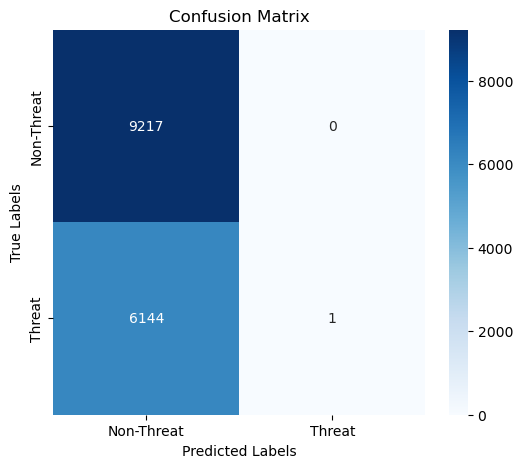

In [85]:
evaluate_model(y_true=sus['label'], y_pred=sus['pred_label'], class_labels=["Not Threat", "Threat"])